# TD4 - Information Extraction and Knowledge Graph Population


In [2]:
# Imports
from transformers import pipeline
import networkx as nx
import matplotlib.pyplot as plt
import re

c:\Users\nicol\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
with open("./doc.txt") as f:
    text = f.read()

sentences = re.split(r'[\n\r]+', text)

print(sentences)

['Geoffrey Everest Hinton (born 6 December 1947) is an English Canadian cognitive psychologist and computer scientist, most noted for his work on artificial neural networks.', 'Since 2013 he divides his time working for Google (Google Brain) and the University of Toronto.', 'In 2017, he cofounded and became the Chief Scientific Advisor of the Vector Institute in Toronto.', 'With David E. Rumelhart and Ronald J. Williams, Hinton was co-author of a highly cited paper published in 1986 that popularized the backpropagation algorithm for training multi-layer neural networks, although they were not the first to propose the approach.', 'Hinton is viewed by some as a leading figure in the deep learning community and is referred to by some as the "Godfather of Deep Learning".', 'The dramatic image-recognition milestone of the AlexNet designed by his student Alex Krizhevsky for the ImageNet challenge 2012 helped to revolutionize the field of computer vision.', 'Hinton was awarded the 2018 Turing

In [17]:
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [18]:
len(sentences)

27

In [19]:
extracted_texts = []

for i, sentence in enumerate(sentences):
    # We need to use the tokenizer manually since we need special tokens.
    extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(sentence, return_tensors=True, return_text=False)[0]["generated_token_ids"]])
    extracted_triplets = extract_triplets(extracted_text[0])
    extracted_texts.append(extracted_triplets)
    print("Sentence extracted:", i, end="\r")
    

print(extracted_texts[0])

[{'head': 'Geoffrey Everest Hinton', 'type': 'date of birth', 'tail': '6 December 1947'}, {'head': 'Geoffrey Everest Hinton', 'type': 'occupation', 'tail': 'computer scientist'}]


In [20]:
for extracted_triplets in extracted_texts:
    print(extracted_triplets)

[{'head': 'Geoffrey Everest Hinton', 'type': 'date of birth', 'tail': '6 December 1947'}, {'head': 'Geoffrey Everest Hinton', 'type': 'occupation', 'tail': 'computer scientist'}]
[{'head': 'Google Brain', 'type': 'developer', 'tail': 'Google'}]
[{'head': 'Vector Institute', 'type': 'located in the administrative territorial entity', 'tail': 'Toronto'}]
[{'head': 'backpropagation', 'type': 'publication date', 'tail': '1986'}]
[{'head': 'Godfather of Deep Learning', 'type': 'field of work', 'tail': 'deep learning'}]
[{'head': 'AlexNet', 'type': 'discoverer or inventor', 'tail': 'Alex Krizhevsky'}]
[{'head': 'Yoshua Bengio', 'type': 'award received', 'tail': 'Turing Prize'}, {'head': 'Yann LeCun', 'type': 'award received', 'tail': 'Turing Prize'}]
[{'head': "King's College", 'type': 'part of', 'tail': 'Cambridge'}]
[{'head': 'Christopher Longuet-Higgins', 'type': 'employer', 'tail': 'University of Edinburgh'}]
[{'head': 'University of Sussex', 'type': 'country', 'tail': 'Britain'}]
[{'hea

## NetworkX

Creation of a graph with the triplets extracted from REBEL.

In [50]:
# Creating an empty directed graph
G = nx.DiGraph()
subject = set()

# Creating nodes
for extracted_triplets in extracted_texts:
    for extracted_triplet in extracted_triplets:
        head_node = extracted_triplet["head"]
        type_node = extracted_triplet["type"]
        tail_node = extracted_triplet["tail"]
        subject.add(head_node)
        # Adding nodes with attributes
        G.add_node(head_node, type=tail_node)

        # Adding edges
        G.add_edge(head_node, tail_node,label=type_node)

print(G.nodes.data())


[('Geoffrey Everest Hinton', {'type': 'computer scientist'}), ('6 December 1947', {}), ('computer scientist', {}), ('Google Brain', {'type': 'Google'}), ('Google', {'type': 'DNNresearch Inc.'}), ('Vector Institute', {'type': 'Toronto'}), ('Toronto', {}), ('backpropagation', {'type': 'neural network'}), ('1986', {}), ('Godfather of Deep Learning', {'type': 'deep learning'}), ('deep learning', {}), ('AlexNet', {'type': 'Alex Krizhevsky'}), ('Alex Krizhevsky', {}), ('Yoshua Bengio', {'type': 'Turing Prize'}), ('Turing Prize', {}), ('Yann LeCun', {'type': 'Turing Prize'}), ("King's College", {'type': 'Cambridge'}), ('Cambridge', {}), ('Christopher Longuet-Higgins', {'type': 'University of Edinburgh'}), ('University of Edinburgh', {}), ('University of Sussex', {'type': 'Britain'}), ('Britain', {}), ('Gatsby Charitable Foundation Computational Neuroscience Unit', {'type': 'University College London'}), ('University College London', {}), ('Canadian Institute for Advanced Research', {'type': '

### Visualizing the graph

In [64]:
def displayNode(node,G):
    connected_nodes = list(G.neighbors(node))

    H = G.subgraph(connected_nodes + [node])
    pos = nx.kamada_kawai_layout(H)
    edge_labels = nx.get_edge_attributes(H, 'label')

    nx.draw(H, pos, with_labels=True,font_size=7)
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)


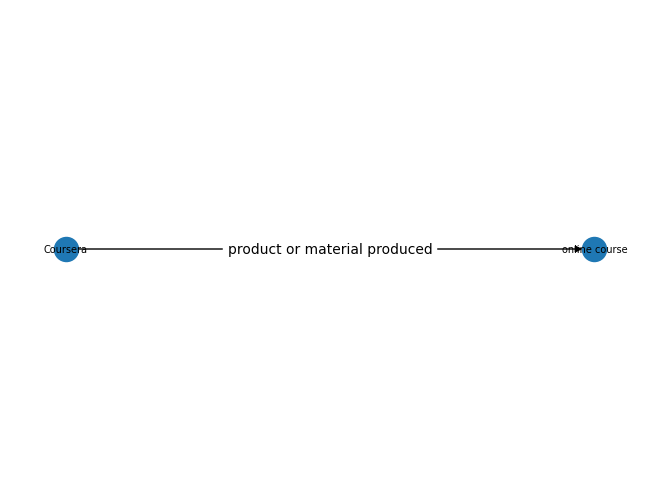

In [93]:
subject = list(subject)
displayNode(subject[28],G)


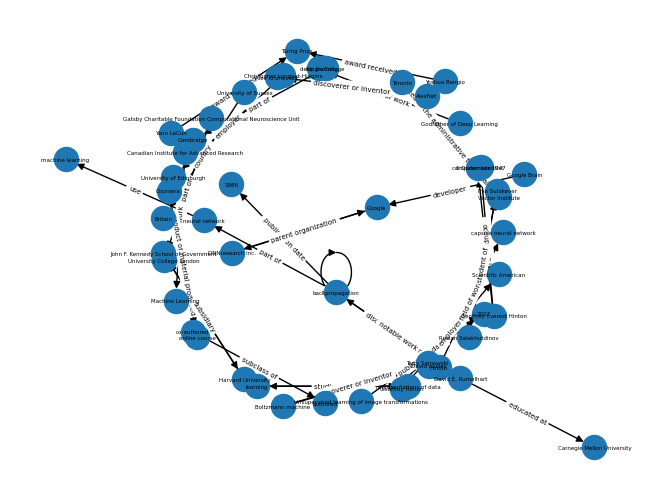

In [52]:
pos = nx.kamada_kawai_layout(G)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True,font_size=4)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=5)

plt.show()